In [50]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, log_loss
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import unittest
import pandas as pd
from sklearn.utils import resample
from solution import MultinomialLogReg, OrdinalLogReg
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder

## Preprocess the data

In [51]:
np.random.seed(42)
# Read the data
df = pd.read_csv("dataset.csv", sep=";")
df_og =df.copy()
# Encode the data
encoder_labs = LabelEncoder()
df["ShotType"] = encoder_labs.fit_transform(df["ShotType"])
encoder = OneHotEncoder(sparse_output=False)
for col in ["Competition", "PlayerType", "Movement"]:
    # Fit and transform the column (convert to dense matrix)
    encoded = encoder.fit_transform(df[[col]])
    # Create new column names for the encoded columns
    encoded_columns = encoder.get_feature_names_out([col])
    # Convert the encoded array to a DataFrame with the new column names
    encoded_df = pd.DataFrame(encoded, columns=encoded_columns)
    # Drop the original column and concatenate the new encoded columns
    df = pd.concat([df.drop(columns=[col]), encoded_df], axis=1)


# Testing functions on the dataset

In [52]:
#################################
# Testing if the regressions work
#################################
# Split into train and test

train, test = train_test_split(df, test_size=0.3, stratify=df["ShotType"])
# Get the features and target
X_train,y_train  = train.drop(columns=["ShotType"]), train["ShotType"]
X_test, y_test = test.drop(columns=["ShotType"]), test["ShotType"]
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train[["Angle", "Distance"]])
X_train.loc[:, ["Angle", "Distance"]] = scaler.transform(X_train[["Angle", "Distance"]])
X_test.loc[:, ["Angle", "Distance"]] = scaler.transform(X_test[["Angle", "Distance"]])
# build the model
model = MultinomialLogReg()
model_pred = model.build(X_train, y_train)
pred = model_pred.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
print(classification_report(y_test, pred_classes))
# Use the other one
model = OrdinalLogReg()
model_pred = model.build(X_train, y_train)
pred = model_pred.predict(X_test)
pred_classes = np.argmax(pred, axis=1)
print(classification_report(y_test, pred_classes))

              precision    recall  f1-score   support

           0       0.83      0.87      0.85       917
           1       0.44      0.13      0.21        30
           2       0.35      0.28      0.31       119
           3       0.60      0.77      0.67       292
           4       0.59      0.24      0.34       132
           5       0.00      0.00      0.00        18

    accuracy                           0.73      1508
   macro avg       0.47      0.38      0.40      1508
weighted avg       0.71      0.73      0.71      1508

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       917
           1       0.00      0.00      0.00        30
           2       0.00      0.00      0.00       119
           3       0.54      0.64      0.58       292
           4       0.17      0.03      0.05       132
           5       0.00      0.00      0.00        18

    accuracy                           0.69      1508
   macro avg       0.24

c:\Users\marko\miniconda3\envs\mlds\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marko\miniconda3\envs\mlds\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marko\miniconda3\envs\mlds\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
df_og["ShotType"].value_counts(sort=False)

ShotType
above head    3055
layup          973
other          439
hook shot      397
dunk            99
tip-in          61
Name: count, dtype: int64

# Part 2.1

In [63]:
# Which column to use as reference? (in the model it's the last one)
y = df["ShotType"].copy()
y.value_counts(), df_og["ShotType"].value_counts()
# y.loc[y == 5] = 99
# y.loc[y == 2] = 5
# y.loc[y == 99] = 2
# y.value_counts(), df_og["ShotType"].value_counts()

(ShotType
 0    3055
 3     973
 4     439
 2     397
 1      99
 5      61
 Name: count, dtype: int64,
 ShotType
 above head    3055
 layup          973
 other          439
 hook shot      397
 dunk            99
 tip-in          61
 Name: count, dtype: int64)

In [64]:
m = 100
X = df.drop(columns = "ShotType")
y = df["ShotType"]
# Scaling the data
scaler = StandardScaler()
X.loc[:,["Angle", "Distance"]] = scaler.fit_transform(X.loc[:,["Angle", "Distance"]])

betas = []
model = MultinomialLogReg()
for i in tqdm(range(m)):
    X_bs, y_bs = resample(X,y)
    model_pred = model.build(X_bs, y_bs)
    betas.append(model_pred.beta)
betas_means = np.mean(betas, axis=0)
betas_stds = np.std(betas, axis=0)

# Save the results
np.save("betas_means.npy", betas_means)
np.save("betas_stds.npy", betas_stds)

100%|██████████| 100/100 [35:19<00:00, 21.19s/it]


In [65]:
betas_means = np.load("betas_means.npy")
betas_stds = np.load("betas_stds.npy")
betas_means = np.vstack([betas_means ,np.zeros_like(betas_means[0]) ]) 
betas_stds = np.vstack([betas_stds ,np.zeros_like(betas_means[0]) ]) 

In [66]:
# Define the column names, adding 'intercept' at the beginning
columns_with_intercept = ["intercept"] + list(df.drop(columns="ShotType").columns)

# Create the DataFrame with the intercept column first
df_betas_means = pd.DataFrame(columns=columns_with_intercept, data=betas_means)


labs = [i for i in range(df["ShotType"].nunique())]
shotTypes_col = encoder_labs.inverse_transform(labs)
# HERE you have to set the correct one to 0-s, and also have to shuffle the SE-s
df_betas_means["ShotType"] = shotTypes_col
# df_betas_means["ShotType"].loc[df_betas_means["ShotType"] == "tip-in"] = "tmp"
# df_betas_means["ShotType"].loc[df_betas_means["ShotType"] == "hook shot"] = "tip-in"
# df_betas_means["ShotType"].loc[df_betas_means["ShotType"] == "tmp"] = "hook shot"
df_betas_means

# REPORT: FMAKE A TABLE (OR GRAPH) FOR EACH OF THE ORIGINAL FEATUERES (BEFORE HOT-ENCODED), AND ONE TABLE (OR GRAPH) FOR ANGLE AND DISTANCE
# WHEN WRITIN THE REPORT LOOK AGAIN AT THE DEFINITIONS OF BASKETBALL STUFF IN THE PAPER
# INTERCEPT INTERPRETATION
# MAYBE PLOT SOME DENSITIES OF BETAS

,intercept,Transition,TwoLegged,Angle,Distance,Competition_EURO,Competition_NBA,Competition_SLO1,Competition_U14,Competition_U16,PlayerType_C,PlayerType_F,PlayerType_G,Movement_dribble or cut,Movement_drive,Movement_no,ShotType
0,7.439487,-0.639869,-5.084592,0.330115,10.000751,0.126333,0.780870,0.030808,5.930131,2.683243,2.580601,3.066980,2.783384,6.977986,-5.226299,6.729248,above head
1,-4.354649,0.405444,6.831955,0.224499,2.850197,0.667065,1.984312,0.441171,-5.928730,0.483106,-0.439561,-1.503862,-1.450767,-3.353915,-1.176582,1.184516,dunk
2,3.234768,-1.002785,-4.892560,0.071311,7.839040,-0.045314,-0.097393,-0.172994,4.107110,1.367277,1.529208,1.628519,1.050999,-4.091094,-1.904050,10.304458,hook shot
3,5.111732,-0.205716,10.514288,0.638284,5.584350,-0.717985,0.307099,-0.295361,5.432637,2.529648,1.813721,2.185477,2.126743,7.658884,8.282889,-9.763220,layup
4,9.527576,-0.540502,-6.456772,0.348174,9.719811,0.286857,1.134560,-0.229787,7.010985,3.408696,2.968317,3.801284,3.713534,3.621566,4.617426,2.206607,other
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,tip-in


## Part 2.2

In [8]:
def multinomial_bad_ordinal_good(num_classes=5, num_data_points=500):
    # Generate some random features, from the uniform distribution
    data = np.random.uniform(0,num_classes,(num_data_points, num_classes))
    cols = [f"{i}" for i in range(num_classes)]
    df = pd.DataFrame(data, columns=cols)
    # Assign the target based on the sum of the featues 
    feature_mean = df.mean(axis=1) + np.random.randn(len(df)) * 0.1 # Add a bit of gaussian noise
    # Assign the class based on the mean quantiles
    df["target"] = pd.qcut(feature_mean, q=num_classes, labels=False, duplicates="drop")
    return df

In [16]:
# TODO bootstrap log loss, accuracy, f1 score
# Test the function, it can't be a too large dataset, otherwise the work the same, report accuracy and F1
df = multinomial_bad_ordinal_good(5,100)
train, test = train_test_split(df, test_size=0.3, stratify=df["target"])
X_train,y_train  = train.drop(columns=["target"]), train["target"]
X_test, y_test = test.drop(columns=["target"]), test["target"]
model = MultinomialLogReg()
model_pred = model.build(X_train, y_train)
pred = model_pred.predict(X_test)
print(log_loss(y_test, pred))
pred_classes = np.argmax(pred, axis=1)
print(classification_report(y_test, pred_classes))
# Use the other one
model = OrdinalLogReg()
model_pred = model.build(X_train, y_train)
pred = model_pred.predict(X_test)
print(log_loss(y_test, pred))
pred_classes = np.argmax(pred, axis=1)
print(classification_report(y_test, pred_classes))

2.14973281269359
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.71      0.83      0.77         6
           2       0.67      1.00      0.80         6
           3       0.75      0.50      0.60         6
           4       0.83      0.83      0.83         6

    accuracy                           0.77        30
   macro avg       0.79      0.77      0.76        30
weighted avg       0.79      0.77      0.76        30

0.6039710493188358
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.71      0.83      0.77         6
           2       0.62      0.83      0.71         6
           3       0.67      0.67      0.67         6
           4       1.00      0.83      0.91         6

    accuracy                           0.77        30
   macro avg       0.80      0.77      0.77        30
weighted avg       0.80      0.77      0.

## Part 3

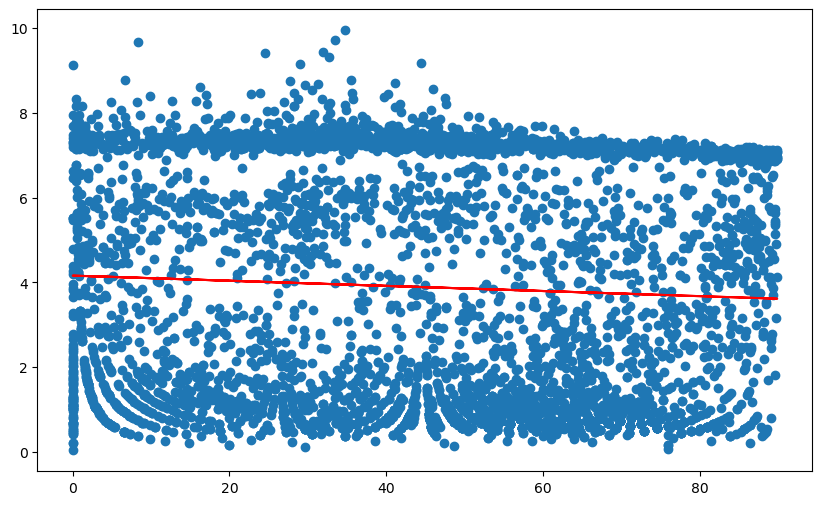

In [229]:
import matplotlib.pyplot as plt
class LinearRegression():
    def build(self, x,y):
        # Add intercept
        y = np.array(y).reshape(-1,1)
        x = np.array(x).reshape(-1,1)
        x = np.c_[np.ones_like(x),x]
        # Use the least-squares formula to get betas
        self.beta = (np.linalg.inv(x.T @ x) @ x.T) @ y
        self.hat = x @(np.linalg.inv(x.T @ x) @ x.T)
        
    def predict(self,x):
        x = np.array(x).reshape(-1,1)
        x = np.c_[np.ones_like(x),x]

        return (self.beta.T @ x.T).flatten()
    

# Get the x ans y 
df = pd.read_csv("dataset.csv", sep=";")
y = df["Distance"].values
x = df["Angle"].values

model = LinearRegression()
# indices = y < y.mean()

# y = y[indices]
# x = x[indices]
model.build(x,y)
preds = model.predict(x)

plt.figure(figsize=(10,6))
plt.plot(x, preds, color="red")
plt.scatter(x,y)
plt.show()

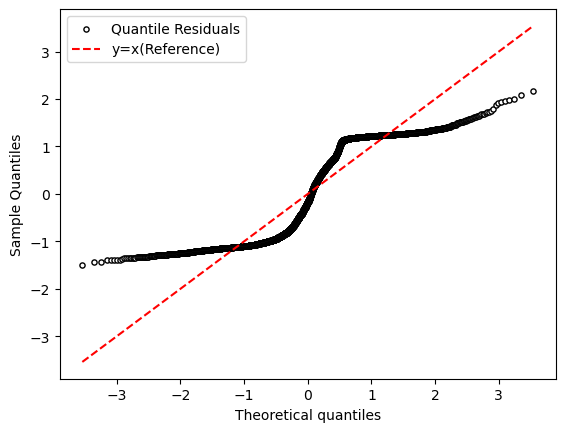

In [230]:
from scipy.stats import norm
# normal q-q plot (8.7.4)
# Get the basic residuals
response_residuals = y - preds
# Then we need the pearson residuals
quantile_residuals = response_residuals  / np.std(response_residuals)
quantile_residuals = sorted(quantile_residuals)
N = len(quantile_residuals)
probabilites = np.linspace(1/(N), N/(N+1), N)
quantiles_theory = norm.ppf(probabilites)
# Step 3: Plot Q-Q plot
plt.scatter(quantiles_theory, quantile_residuals, label="Quantile Residuals",
             color="white", s=14, edgecolors="k")
plt.plot(quantiles_theory, quantiles_theory, 'r--', label="y=x(Reference)")
plt.ylabel("Sample Quantiles")
plt.xlabel("Theoretical quantiles")
plt.legend()
plt.show()

Text(0, 0.5, 'Residuals')

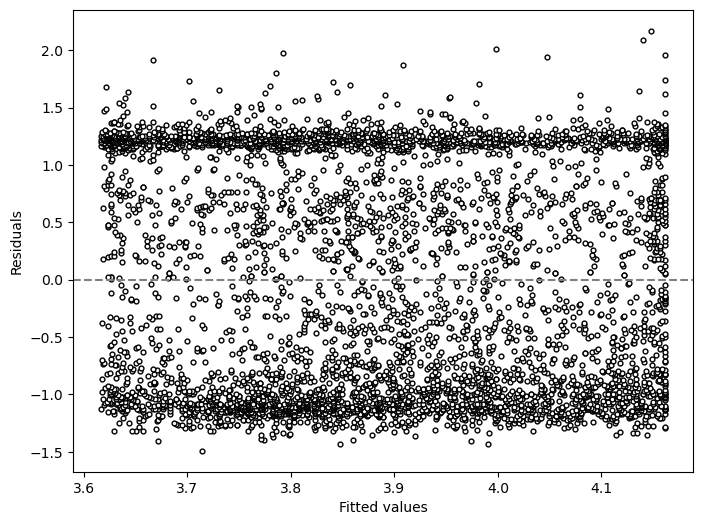

In [231]:
# residuals vs fitted values, quantile residuals
# Plot residuals vs. fitted values
plt.figure(figsize=(8,6))
plt.scatter(preds,quantile_residuals, color="white", edgecolors="black", s = 12)
plt.axhline(0, color="grey", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")



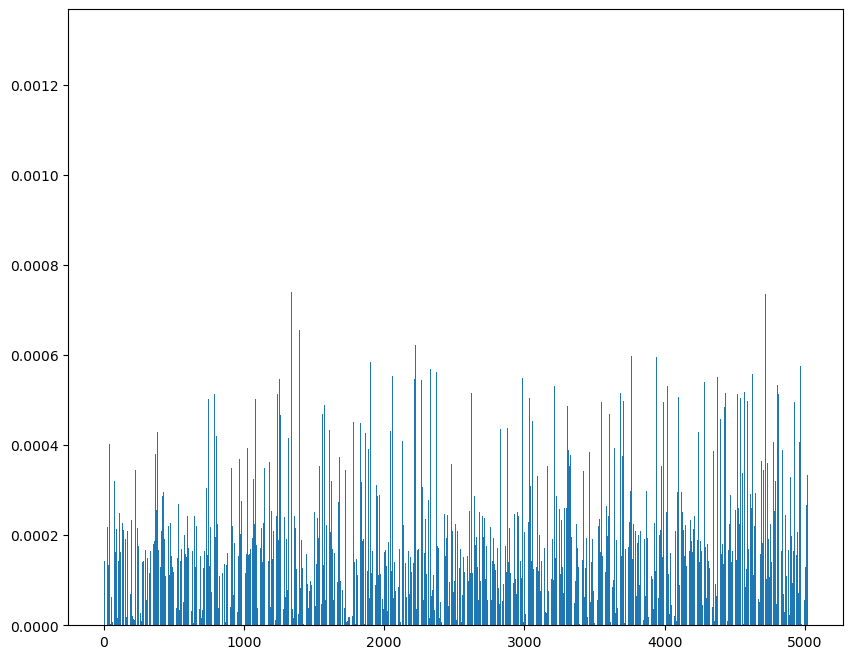

In [ ]:
# Cooks distance plot
# Get the hat matrix
mse = np.mean((response_residuals)**2)
diags = np.diag(model.hat)
cook = response_residuals**2 / (2 * mse)  * diags /(1-diags)**2

plt.figure(figsize=(10,8))
plt.bar(range(len(cook)), cook)
plt.show()

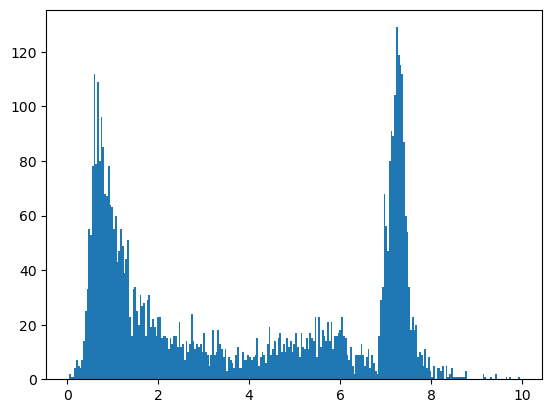

In [196]:
# plot the distribution of shot lengths
import matplotlib.pyplot as plt

plt.hist(y, bins = 255)
plt.show()